In [203]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy import interpolate

## Earthquakes in New Zealand

Earthquake data for any region in the world can be downloaded from https://ds.iris.edu/ieb/. The database provides earthquakes from USGS with date, moment magnitude, location, depth and region. We can read the downloaded .csv file with Pandas module:

In [204]:
data = pd.read_csv("data/nz_largest_eq_since_1970.csv")
data.head()

,year,month,day,utc_time,mag,lat,lon,depth_km,region,iris_id,timestamp
0,2009,7,15,09:22:31,7.8,-45.8339,166.6363,20.9,"OFF W. COAST OF S. ISLAND, N.Z.",2871698,1247649751
1,2016,11,13,11:02:59,7.8,-42.7245,173.0647,22.0,"SOUTH ISLAND, NEW ZEALAND",5197722,1479034979
2,2003,8,21,12:12:47,7.2,-45.0875,167.0892,6.8,"SOUTH ISLAND, NEW ZEALAND",1628007,1061467967
3,2001,8,21,06:52:06,7.1,-36.8010,-179.7230,33.5,"EAST OF NORTH ISLAND, N.Z.",1169374,998376726
4,2004,11,22,20:26:23,7.1,-46.4964,164.8273,7.6,"OFF W. COAST OF S. ISLAND, N.Z.",1888053,1101155183


At first, let's plot downloaded data on a map:

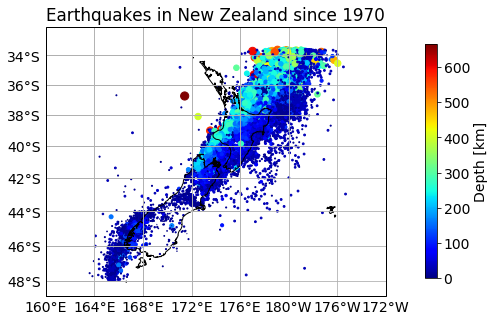

In [205]:
plt.rcParams.update({'font.size': 14})

central_lon, central_lat = 170, -50
extent = [160,188,-48,-32]

fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)), figsize=(7,7))

ax.set_extent(extent)
ax.coastlines(resolution='10m')
ax.set_title("Earthquakes in New Zealand since 1970")

# Create a scatter plot
scatplot = ax.scatter(data.lon, data.lat, c=data.depth_km,
                      s=data.depth_km/10, cmap="jet",
                      transform=ccrs.Geodetic())

# Create colourbar
cbar = plt.colorbar(scatplot, ax=ax, fraction=0.03, pad=0.1, label='Depth [km]')

# Sort out gridlines and their density
xticks_extent = list(np.arange(160, 180, 4)) + list(np.arange(-200,-170,4))
yticks_extent = list(np.arange(-60, -30, 2))

gl = ax.gridlines(linewidths=0.1)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(xticks_extent)
gl.ylocator = mticker.FixedLocator(yticks_extent)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

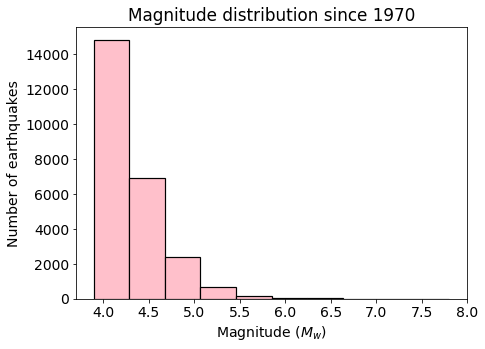

In [206]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(7,5))
plt.title('Magnitude distribution since 1970')
n,bins,patches = plt.hist(data.mag, color='pink',edgecolor='black', linewidth=1.2)
plt.xlabel('Magnitude ($M_w$)')
plt.ylabel('Number of earthquakes')
plt.show()

b-value

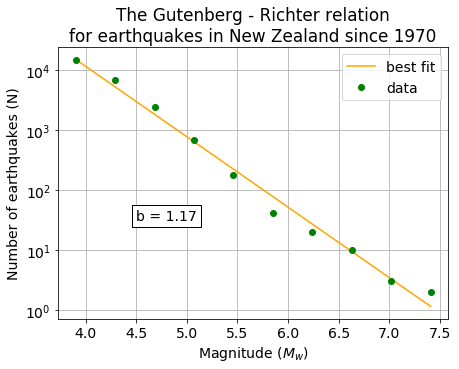

In [207]:
z = np.polyfit(bins[:-1], n, 1)
x = np.linspace(bins[0], bins[-2])
p = np.poly1d(z)

plt.figure(figsize=(7,5))
coefficients = np.polyfit(bins[:-1], np.log10(n), 1)
polynomial = np.poly1d(coefficients)
plt.plot(x,x*polynomial[1]+polynomial[0], label='best fit', color='orange')


#print(r'log10(N) = %.2f - %.2f*M' % (polynomial[0],-polynomial[1]))


plt.title('The Gutenberg - Richter relation\nfor earthquakes in New Zealand since 1970')
plt.plot(bins[:-1], np.log10(n), 'o', color='green', label='data')
plt.xlabel('Magnitude ($M_w$)')
plt.ylabel("Number of earthquakes (N)")
plt.legend(loc='best')

plt.yticks([0,1,2,3,4], ["$10^%g$" % i for i in [0,1,2,3,4]])

plt.text(4.5, 1.5, "b = %.2f" % (-polynomial[1]), fontsize=14,
         bbox=dict(facecolor='white', edgecolor="black"))

plt.grid(True)
plt.show()


Moment magnitude $M_w$ can be used to calculate scalar seismic moment $M_0$ via relationship:

$$ M_w = \frac{2}{3} (log_{10} M_0 -9.1) \Rightarrow M_0 = 10^{3/2 M_w +9.1} $$

Seismic moment is given in N.m and has dimenstions of a torque.

In [86]:
def seismicMoment(mw):
    return 10**(3./2.*mw+9.1)

## PREM

In [196]:
prem = pd.read_csv("data/PREM500.csv") #http://ds.iris.edu/spud/earthmodel/9785674
prem.head()

,radius_m,density_kgm3,vp_ms,vs_ms
0,0,13088.50,11262.20,3667.80
1,12858,13088.46,11262.17,3667.78
2,25716,13088.36,11262.10,3667.73
3,38574,13088.18,11261.97,3667.64
4,51432,13087.92,11261.79,3667.51


$$ V_p = \sqrt{\frac{\kappa +\frac{3}{4}\mu}{\rho}}$$
$$ V_s = \sqrt{\frac{\kappa}{\rho}} $$ 

In [200]:
def calcShearModulus(vs, rho):
    return vs**2*rho

def calcBulkModulus(vp, rho, mu):
    return vp**2*rho-4/3.*mu

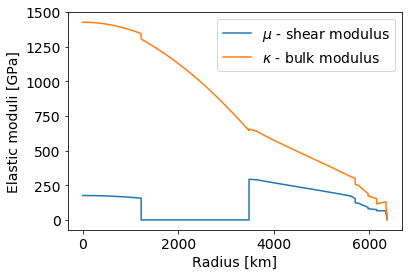

In [201]:
plt.plot(prem.radius_m/1000., calcShearModulus(prem.vs_ms, prem.density_kgm3)/1e9,
        label="$\mu$ - shear modulus")

plt.plot(prem.radius_m/1000., calcBulkModulus(prem.vp_ms, prem.density_kgm3,
                                        calcShearModulus(prem.vs_ms, prem.density_kgm3))/1e9,
        label="$\kappa$ - bulk modulus")

plt.xlabel("Radius [km]")
plt.ylabel("Elastic moduli [GPa]")
plt.legend(loc="best")
plt.show()

In [208]:
x = prem.radius_m/1000.
y = calcShearModulus(prem.vs_ms, prem.density_kgm3)/1e9
f = interpolate.interp1d(x, y)

xnew = np.linspace(0,np.max(prem.radius_m)/1e3)
ynew = f(xnew)

data["shear_modulus"] = f(np.max(prem.radius_m)/1000. - data.depth_km)

x = prem.radius_m/1000.
y = calcBulkModulus(prem.vp_ms, prem.density_kgm3, calcShearModulus(prem.vs_ms, prem.density_kgm3))/1e9
f = interpolate.interp1d(x, y)

xnew = np.linspace(0,np.max(prem.radius_m)/1e3)
ynew = f(xnew)

data["bulk_modulus"] = f(np.max(prem.radius_m)/1000. - data.depth_km)


$$ M_0 = \mu D A$$

where $\mu$ is shear modulus, $D$ is fault slip (m) and $A$ is fault area (m$^2$)

In [209]:
data["seismic_moment"] = seismicMoment(data.mag)
data["DA"] = data.seismic_moment/data.shear_modulus/1e9 #displaced volume???